In [1]:
from os.path import join
import json
import csv
import glob
import os

import rpy2.rinterface
from pandas import read_csv, DataFrame, Series
from qiime2 import Artifact
from statsmodels.stats.weightstats import DescrStatsW
from scipy.stats import t, sem
from IPython.display import Image

In [2]:
%reload_ext rpy2.ipython

In [3]:
%%R 
library(ggplot2)

In [4]:
empo3_dir = '/Users/benkaehler/Data/empo_3/'

In [5]:
columns = ['sample type', 'sample', 'fold']
data = {c:[] for c in columns}
for type_dir in glob.glob(join(empo3_dir, '*')):
    if not os.path.exists(join(type_dir, 'results', 'weights.qza')):
        continue
    type_ = os.path.basename(type_dir)
    if type_ in ('sterile-water-blank', 'single-strain', 'mock-community', 'nick', 'plant-surface'):
        continue
    for fold_dir in glob.glob(join(type_dir, 'tmp', 'fold-*')):
        _, fold = fold_dir.rsplit('-', 1)
        with open(join(fold_dir, 'sample_test.json')) as fh:
            try:
                samples = json.load(fh)
            except UnicodeDecodeError:
                print(join(fold_dir, 'sample_test.json'), 'is corrupted')
        data['sample'].extend(samples)
        data['sample type'].extend([type_]*len(samples))
        data['fold'].extend([fold]*len(samples))
folds = DataFrame(data)

In [6]:
abundances = read_csv(join(empo3_dir, 'abundances.tsv'), sep='\t')
abundances = abundances.set_index(['sample type', 'sample'])
prf = read_csv(join(empo3_dir, 'eval_taxa_prf.tsv'), sep='\t')
prf = prf[prf['sample type']  != 'plant-surface']
prf = prf.join(abundances, ['sample type', 'sample'])

In [7]:
corrupted_samples = list(set(prf['sample']) - set(folds['sample']))
corrupted_samples = DataFrame({'sample': corrupted_samples})
corrupted_samples['sample type'] = 'animal-corpus'
corrupted_samples['fold'] = '0'
folds = folds.append(corrupted_samples)
folds = folds.set_index(['sample type', 'sample'])
prf = prf.join(folds, ['sample type', 'sample'])

In [8]:
prf = prf[(prf['sample type'] != 'single-strain') &
          (prf['sample type'] != 'sterile-water-blank') &
          (prf['sample type'] != 'mock-community') &
          (prf['sample type'] != 'plant-surface')]
prf = prf[(prf['class weights'] == 'bespoke70') |
          (prf['class weights'] == 'uniform70')]
prf = prf[prf['method'] == 'weighted']
level7 = prf[((prf['level'] == 7) & (prf['class weights'] == 'bespoke70')) |
             ((prf['level'] == 6) & (prf['class weights'] == 'uniform70'))]

In [9]:
bespoke = level7[level7['class weights'] == 'bespoke70']
bespoke.rename(columns={'F-measure':'bespoke'}, inplace=True)
uniform = level7[level7['class weights'] == 'uniform70']
uniform.rename(columns={'F-measure':'uniform'}, inplace=True)
uniform = uniform.set_index(['sample type', 'sample', 'fold'])
for_diff = bespoke.join(uniform, ['sample type', 'sample', 'fold'], rsuffix='_uniform')

In [10]:
grouped = for_diff.groupby(['sample type', 'class weights', 'fold'])
def weighted_stats(x):
    d1 = DescrStatsW(x['bespoke'] - x['uniform'], weights=x['abundance'])
    return Series([d1.mean], index=['mean'])
figure1 = grouped.apply(weighted_stats)
figure1.reset_index(inplace=True)

In [11]:
grouped = figure1.groupby(['sample type', 'class weights'])
def weighted_stats(x):
    mu = x['mean'].mean()
    se = sem(x['mean'])
    lower, upper = t.interval(0.95, 5, mu, se)
    return Series([mu, lower, upper], index=['mean', 'lower', 'upper'])
figure1 = grouped.apply(weighted_stats)
figure1.reset_index(inplace=True)

In [12]:
old_labels = 'uniform70', 'bespoke70'
new_labels = 'Uniform Genus Level', 'Bespoke Species Level'
for old, new in zip(old_labels, new_labels):
    figure1.loc[figure1['class weights'] == old, 'class weights'] = new
old_labels = [
    'animal-corpus',
    'animal-distal-gut',
    'animal-proximal-gut',
    'animal-secretion',
    'animal-surface',
    'plant-corpus',
    'plant-rhizosphere',
    'plant-surface',
    'sediment-non-saline',
    'soil-non-saline',
    'surface-non-saline',
    'water-non-saline',
    'sediment-saline',
    'surface-saline',
    'water-saline'
]
new_labels = [
    'Animal corpus',
    'Animal distal gut',
    'Animal proximal gut',
    'Animal secretion',
    'Animal surface',
    'Plant corpus',
    'Plant rhizosphere',
    'Plant surface',
    'Sediment (non-saline)',
    'Soil (non-saline)',
    'Surface (non-saline)',
    'Water (non-saline)',
    'Sediment (saline)',
    'Surface (saline)',
    'Water (saline)'
]
for old, new in zip(old_labels, new_labels):
    figure1.loc[figure1['sample type'] == old, 'sample type'] = new
figure1['direction'] = ['none']*len(figure1)
figure1.loc[figure1['mean'] >= 0., 'direction'] = 'Bespoke Species Level'
figure1.loc[figure1['mean'] < 0., 'direction'] = 'Uniform Genus Level'

In [13]:
%%R -i figure1
figure1$sample.type = factor(figure1$sample.type, levels=c(
    'Animal corpus',
    'Animal distal gut',
    'Animal proximal gut',
    'Animal secretion',
    'Animal surface',
    'Plant corpus',
    'Plant rhizosphere',
    'Plant surface',
    'Sediment (non-saline)',
    'Soil (non-saline)',
    'Surface (non-saline)',
    'Water (non-saline)',
    'Sediment (saline)',
    'Surface (saline)',
    'Water (saline)'))
figure1$class.weights = factor(figure1$class.weights, levels=c(
    'Uniform Genus Level', 'Bespoke Species Level'
))
cbPalette <- c("#009E73", "#E69F00")
ggplot(data=figure1, aes(x=sample.type, y=mean, fill=direction)) +
  geom_bar(stat="identity", position="identity") +
  coord_flip() + 
  theme_bw() +
  theme(legend.position="bottom", 
        legend.direction="horizontal") +
  labs(x='EMPO3 Habitat', y='Unfair F-measure Difference') +
  geom_errorbar(aes(ymin=lower, ymax=upper), position=position_dodge()) +
  scale_fill_manual(values=cbPalette) +
  guides(fill=guide_legend(title="More Accurate", nrow=2, byrow=TRUE))
ggsave(file="figure3.png", width=5, height=5, dpi=300)

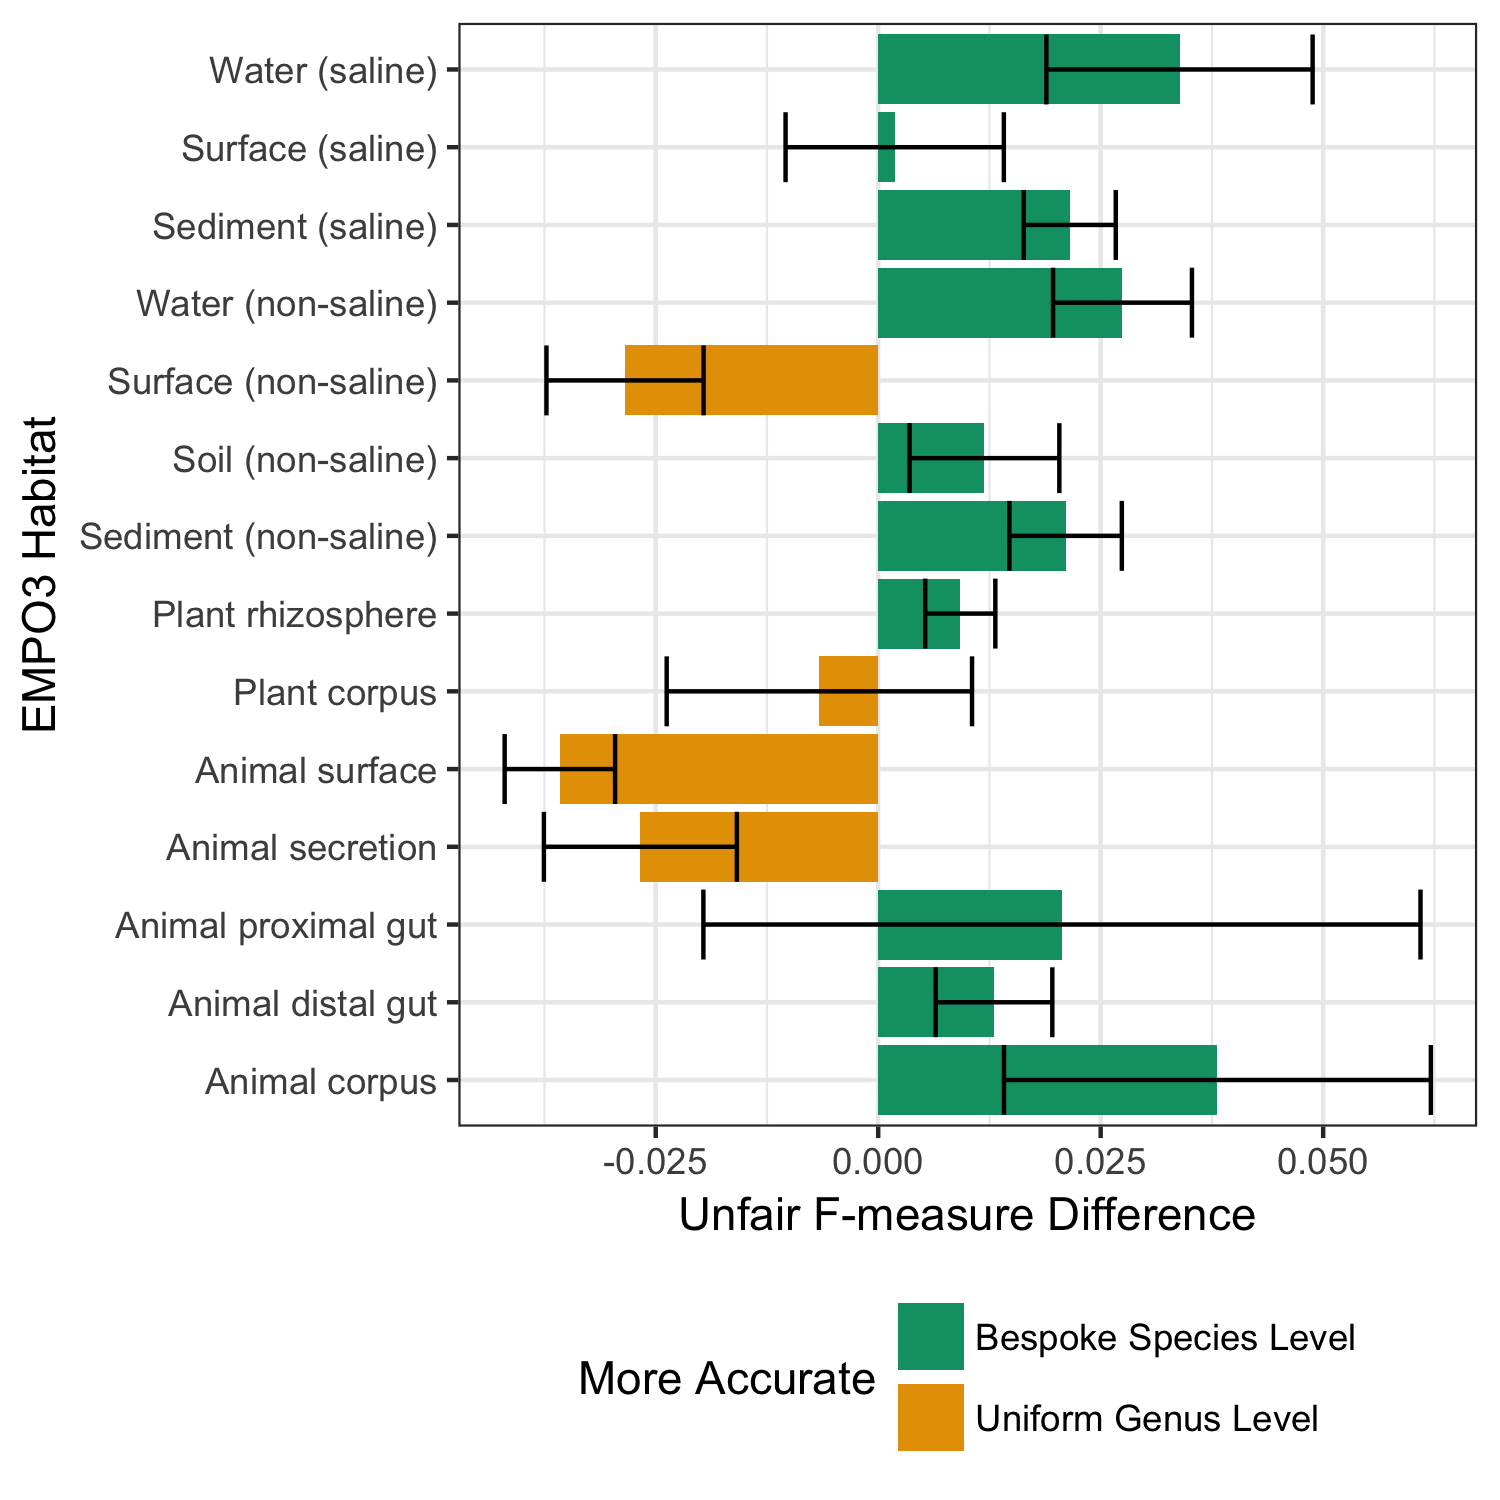

In [15]:
Image("figure3.png")

In [16]:
max(figure1['upper'] - figure1['lower'])

0.08058142295246032